In [27]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)

import matplotlib.pyplot as plt
%matplotlib inline

# Import files & Merge

In [21]:
Steps0 = pd.read_csv("Steps.csv")
Calendar = pd.read_csv("Calendar.csv")
Sleep = pd.read_csv("Sleep_Schedule.csv")
Weather = pd.read_csv("weather.csv")

#Weather['date'] = pd.to_datetime(Weather['date'])

Sleep.columns = Sleep.columns.str.strip()
Calendar.columns = Calendar.columns.str.strip()


#Calendar columns we want 
Weather = Weather[['date','temp_min','temp_max','is_rain']]
Calendar = Calendar[['Date','AD_Month','AH_Month',"Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Adha","Sch_Eid_Fatr","National_Day","National_Day_Ext","AD_WeekdayNum"]]
Steps0 = Steps0[["Date","Steps"]]
Sleep = Sleep[['Date','Woke_Hour']]



Merged = pd.merge(Steps0,Calendar,how="left",on="Date")
Merged = pd.merge(Merged,Sleep,how='left',on="Date")
Merged = pd.merge(Merged,Weather,how='left',left_on='Date',right_on='date')
Merged.sort_values('Date',inplace=True)
del Merged['date']
del Merged['Sch_Eid_Adha']
Merged['is_rain'] = Merged['is_rain'].astype('int')
Merged = Merged.sort_values("Date")
Merged = Merged.iloc[:,1:]

In [22]:
Merged

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,Woke_Hour,temp_min,temp_max,is_rain
0,3140,6,9,1,0,1,0,0,0,5,18,86,111,0
1,9810,6,9,1,0,1,0,0,0,6,20,88,113,0
2,6551,6,9,1,0,1,0,0,0,0,6,90,111,0
3,6107,6,9,1,0,1,0,0,0,1,6,88,113,0
4,2569,6,9,1,0,1,0,0,0,2,6,86,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,0,0,0,0,0,3,3,73,100,0
1203,3702,9,2,0,0,0,0,0,0,4,6,73,100,0
1204,3939,9,2,0,0,0,0,0,0,5,8,77,104,0
1205,2847,9,2,0,0,0,0,0,1,6,4,77,102,0


# Correlation Analysis

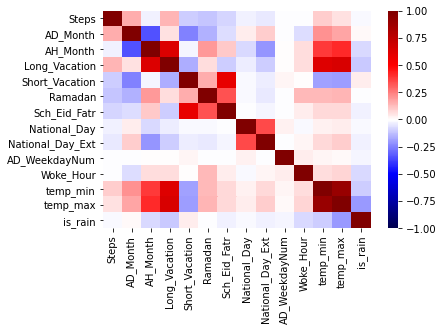

In [23]:
## correlation matrix,  and pair plot
Merged.corr()["Steps"]
sns.heatmap(Merged.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

# Generate Lag values

In [24]:

for i in range(1,9):
    Merged['Lag'+str(i)] = Merged['Steps'].shift(i)
Merged

Merged = Merged.dropna()

# Normalization

In [25]:
Norm_Merged=(Merged-Merged.mean())/Merged.std()
Norm_Merged

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
8,0.077199,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,1.497814,...,1.077436,-0.185698,-0.552813,-0.862393,-0.390251,-0.302354,0.780624,0.916101,1.909126,-0.129858
9,-0.415612,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-1.497814,...,0.952312,-0.185698,0.076810,-0.552115,-0.861920,-0.389947,-0.302709,0.780178,0.912927,1.909052
10,2.442935,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.998542,...,0.952312,-0.185698,-0.416165,0.077325,-0.551660,-0.861598,-0.390282,-0.302927,0.777207,0.912829
11,2.048748,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.499271,...,0.764625,-0.185698,2.443333,-0.415506,0.077743,-0.551350,-0.861828,-0.390481,-0.304276,0.777105
12,1.979528,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,0.000000,...,0.639501,-0.185698,2.049015,2.443160,-0.415059,0.078030,-0.551649,-0.861929,-0.391699,-0.304404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,0.274140,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.000000,...,0.389252,-0.185698,0.578363,-0.251025,-0.272333,0.281085,0.238651,-0.789375,-0.383446,-0.362789
1203,0.043814,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.499271,...,0.389252,-0.185698,0.273816,0.578733,-0.250587,-0.272034,0.280600,0.238319,-0.789995,-0.383576
1204,0.116403,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.998542,...,0.639501,-0.185698,0.043414,0.274274,0.579122,-0.250289,-0.272395,0.280260,0.236160,-0.790135
1205,-0.218058,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,7.147572,1.497814,...,0.514377,-0.185698,0.116027,0.043939,0.274681,0.579390,-0.250655,-0.272619,0.278037,0.236045


# Modelling

In [ ]:


#features = ["AD_Month","AH_Month","Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Adha","Sch_Eid_Fatr","National_Day","National_Day_ext","AD_Weekdaynum","Woke_Hour"]


y = Merged.iloc[:,:1]
x_org = Merged.iloc[:,1:]
x_org
x = x_org.copy()
#x = x.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","AD_WeekdayNum","Long_Vacation","Short_Vacation","Ramadan","National_Day_Ext","Woke_Hour"]].copy()
x = x.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","Long_Vacation","AD_Month","temp_min"]].copy()

#del x['Sch_Eid_Adha']
#del x['Sch_Eid_Fatr']
#del x['National_Day']
#del x['National_Day_Ext']
#del x['Woke_Hour']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))
#y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
mean_absolute_error(lm.predict(X_test),y_test)
# Create your model
#model = sm.OLS(y, X)
#lm.predict(X_test)
# Fit your model to your training set
#fit = model.fit()

# Print summary statistics of the model's performance
#fit.summary()
preds = lm.predict(X_train) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y_train, kind='reg')

#  

## -- Cross- Validation

In [12]:

# selected_columns =  Merged.loc[:,["Lag1","Lag2","Lag3","Lag4","Lag5","Lag6","Lag7","Long_Vacation","AD_Month","temp_min"]].copy()


# y = selected_columns.iloc[:,:1]
# x_org = selected_columns.iloc[:,1:]
# selected_columns
kf = KFold(n_splits=5, shuffle=True, random_state=0)



,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Long_Vacation,AD_Month,temp_min
8,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0,1,6,93
9,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,1,6,82
10,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,1,6,81
11,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,1,6,84
12,10248.0,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,1,6,81
...,...,...,...,...,...,...,...,...,...,...
1202,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0,0,9,73
1203,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,0,9,73
1204,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,0,9,77
1205,3939.0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,0,9,77


## -- Regularization

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

params = {"alpha": np.linspace(0, 1, num=100)}
GS = GridSearchCV(Lasso(), param_grid=params, cv=kf, return_train_score=False)
GS.fit(X_train, y_train)
GS.best_estimator_.alpha

cross_val_score(Lasso(alpha= GS.best_estimator_.alpha), X_train, y_train, cv=kf)

C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2359107061.909729, tolerance: 773523.2204697466
  model = cd_fast.enet_coordinate_descent(
C:\Users\ialzu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


array([0.05406769, 0.23086804, 0.36930981, 0.44495194, 0.28134055])

0.3574665525490285


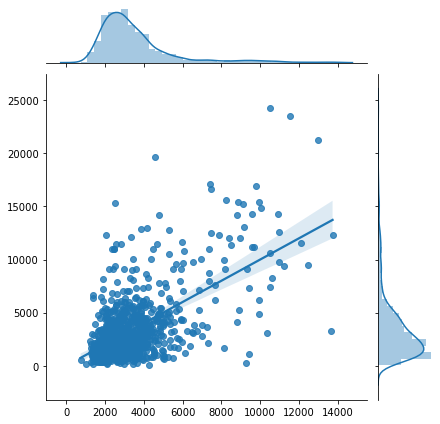

In [44]:
# loop through each feature and log r squared
rsq = []
mse = []
features = ["is_rain","temp_min","temp_max","AD_Month","AH_Month","Long_Vacation","Short_Vacation","Ramadan","Sch_Eid_Adha","Sch_Eid_Fatr","National_Day","National_Day_Ext","AD_WeekdayNum","Woke_Hour"]
for feature in features:
    x = x_org.copy()
    x = x.loc[:,[feature]].copy()
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    rsq.append(lm.score(X_test,y_test))
    mse.append(mean_absolute_error(lm.predict(X_test),y_test))
    #y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
    
list(zip(features,rsq))

[('is_rain', -0.0052751593886384285),
 ('temp_min', 0.008070591527205129),
 ('temp_max', 0.0018472179881753314),
 ('AD_Month', 0.006529392232651476),
 ('AH_Month', -0.0239820285048693),
 ('Long_Vacation', 0.028176756272644377),
 ('Short_Vacation', 0.003504125152054116),
 ('Ramadan', 0.008162157896928313),
 ('Sch_Eid_Adha', -0.004284802024396406),
 ('Sch_Eid_Fatr', 0.00370217457120936),
 ('National_Day', -0.0040274452651380965),
 ('National_Day_Ext', -0.001418733192048327),
 ('AD_WeekdayNum', -0.006381166636464819),
 ('Woke_Hour', -0.012088361021947103)]

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Regression:", r2_score(y_test, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
print("Gradient Boosted Regression:", r2_score(y_test, y_pred))

In [ ]:
Steps = Steps.dropna()
y = Steps.iloc[:,1:2]
x = Steps.iloc[:,2:]
#split 800, the rest 407
X_train = x[:800]
X_test = x[800:]
y_train = y[:800]
y_test = y[800:]

X_test

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
#print(X_test)
score = lm.score(X_test,y_test)
#y, X = patsy.dmatrices('Steps ~  AD_WeekdayNum', data=Merged, return_type="dataframe")
print(mean_absolute_error(lm.predict(X_test),y_test))
print(score)

In [ ]:
lm.predict(pd.DataFrame(columns=['Lag1'],data=[7]))